Data base link /content/drive/MyDrive/low_freq

# Modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
import os

py_file_location = "/content/drive/My Drive/EEE312"
sys.path.append(os.path.abspath(py_file_location))

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import datetime
import time
import math
import glob
from Metrics import *
from keras.models import load_model
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Conv1D, Bidirectional,Flatten, Reshape,GRU
from tensorflow.keras.utils import plot_model
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l1

# Preprocessing Data

In [ ]:
from Preprocessing import create_house_dataframe, date

house_list = [1,2,3,4,5,6]
df = create_house_dataframe(house_list)
dates = date(house_list, df)

House 1 finish:
                     mains_1  mains_2  ...  washer_dryer_19  washer_dryer_20
2011-04-18 13:22:13   222.20   118.83  ...              0.0              0.0
2011-04-18 13:22:16   223.17   119.19  ...              0.0              0.0
2011-04-18 13:22:20   223.60   118.92  ...              0.0              0.0
2011-04-18 13:22:23   222.91   119.16  ...              0.0              0.0
2011-04-18 13:22:26   222.94   118.83  ...              0.0              0.0

[5 rows x 20 columns]
House 2 finish:
                     mains_1  mains_2  ...  dishwaser_10  disposal_11
2011-04-18 05:31:40    15.71    22.61  ...           1.0          0.0
2011-04-18 05:31:44    15.71    22.61  ...           0.0          0.0
2011-04-18 05:31:47    15.72    22.61  ...           1.0          0.0
2011-04-18 05:31:50    15.70    22.57  ...           0.0          0.0
2011-04-18 05:32:05    15.64    22.61  ...           1.0          0.0

[5 rows x 11 columns]
House 3 finish:
                     mai

In [ ]:
for i in [1,2,3,4,5,6]:
    print(df[i].columns.values)

['mains_1' 'mains_2' 'oven_3' 'oven_4' 'refrigerator_5' 'dishwaser_6'
 'kitchen_outlets_7' 'kitchen_outlets_8' 'lighting_9' 'washer_dryer_10'
 'microwave_11' 'bathroom_gfi_12' 'electric_heat_13' 'stove_14'
 'kitchen_outlets_15' 'kitchen_outlets_16' 'lighting_17' 'lighting_18'
 'washer_dryer_19' 'washer_dryer_20']
['mains_1' 'mains_2' 'kitchen_outlets_3' 'lighting_4' 'stove_5'
 'microwave_6' 'washer_dryer_7' 'kitchen_outlets_8' 'refrigerator_9'
 'dishwaser_10' 'disposal_11']
['mains_1' 'mains_2' 'outlets_unknown_3' 'outlets_unknown_4' 'lighting_5'
 'electronics_6' 'refrigerator_7' 'disposal_8' 'dishwaser_9' 'furance_10'
 'lighting_11' 'outlets_unknown_12' 'washer_dryer_13' 'washer_dryer_14'
 'lighting_15' 'microwave_16' 'lighting_17' 'smoke_alarms_18'
 'lighting_19' 'bathroom_gfi_20' 'kitchen_outlets_21' 'kitchen_outlets_22']
['mains_1' 'mains_2' 'lighting_3' 'furance_4' 'kitchen_outlets_5'
 'outlets_unknown_6' 'washer_dryer_7' 'stove_8' 'air_conditioning_9'
 'air_conditioning_10' 'misc

# Fridge

## Prep

In [ ]:
X1 = df[1]['mains_1'].values.astype(np.float32)
y1 = df[1]['refrigerator_5'].values.astype(np.float32)
X2 = df[2]['mains_2'].values.astype(np.float32)
y2 = df[2]['refrigerator_9'].values.astype(np.float32)
X3 = df[3]['mains_2'].values.astype(np.float32)
y3 = df[3]['refrigerator_7'].values.astype(np.float32)
# X4 = df[4]['mains_1'].values.astype(np.float32)
# y4 = df[4]['refrigerator_18'].values.astype(np.float32)
X5 = df[5]['mains_2'].values.astype(np.float32)
y5 = df[5]['refrigerator_18'].values.astype(np.float32)
X6 = df[6]['mains_2'].values.astype(np.float32)
y6 = df[6]['refrigerator_8'].values.astype(np.float32)

Text(0.5, 1.0, 'Aggregated and Refrigerator Power')

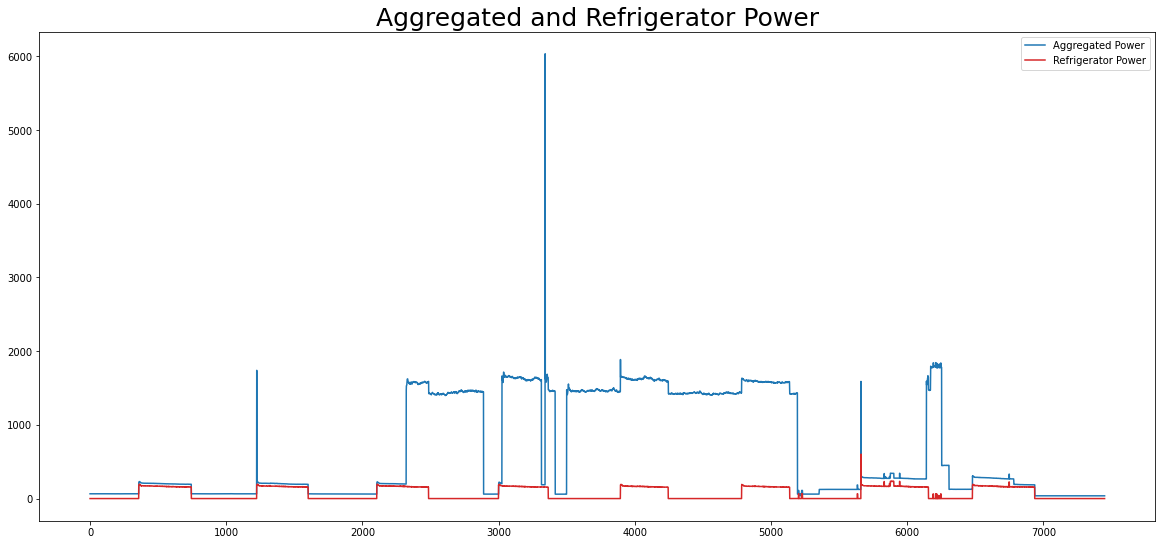

In [ ]:
plt.rcParams["figure.figsize"] = [20,9]
plt.plot((X5)[70000:80000], color = 'C0', label = 'Aggregated Power')
plt.plot((y5)[70000:80000], color = 'C3', label = 'Refrigerator Power')
plt.legend()
plt.title('Aggregated and Refrigerator Power',fontsize=25)

In [ ]:
def remove_abnormal_points(y,left_threshold=200,right_threshold=80):
    y_ = []
    for i,value in enumerate(y):
      
        if i == 0 or i==len(y)-1:
            y_.append(y[i])
        else:
            if y[i]-y[i-1]>left_threshold and y[i]-y[i+1]>right_threshold:
#                        print('index:',i)
                y_.append(y[i+1]+1)
            else:
                y_.append(y[i])
    return np.array(y_)

def get_differential_sequence(X):      
    X_d = []
    pre_item = 0
    for item in X:
        X_d.append(item-pre_item)
        pre_item = item
    X_d = np.array(X_d) # shape = (samples,)
    return X_d

def get_odd_data(X_o, y_o, MAX_X, MAX_y):
    #X_o,y_o = get_house_raw_data(house, self.appliance) 
            
    X_o = remove_abnormal_points(X_o)  
    X_o = X_o/MAX_X # (samples,1)
    #X_d = get_differential_sequence(X_o)  # (samples,)
    #X_dd = get_differential_sequence(X_d) # (samples,)
            
    y_o = remove_abnormal_points(y_o) 
    y_o = y_o/MAX_y # (samples,1)
    #y_d = get_differential_sequence(y_o)  # (samples,)
            
    X = np.expand_dims(X_o,1)  # (samples,3)
    y = np.expand_dims(y_o,1)       # (samples,3)
            
    return X,y 

def shift_segment(X,y,seg_length,stride,print_info=True):
    '''
    X is X_o-X_d-X_dd  shape = (samples,3)
    y is y_o-y_d       shape = (samples,2)
    '''
    X_o_seg = []
    #X_d_seg = []
    #X_dd_seg = []
    y_o_seg = []
    #y_d_seg = []
      
    for i in range(len(X)-seg_length+1):
        if i%stride==0:
            assert len(X[i:i+seg_length]) == seg_length
            X_o_seg.append(  X[i:i+seg_length].reshape(-1) ) 
            #X_d_seg.append(  X[i:i+seg_length,1] )
            #X_dd_seg.append( X[i:i+seg_length,2] )

            y_o_seg.append(  y[i+seg_length//2-1,0] )
            #y_d_seg.append(  y[i+seg_length//2-1,1] )
    if print_info==True:           
        print(' '*7,'sequence length = {}'.format(len(X)))
        print(' '*7,'windows length = {}'.format(seg_length))
        print(' '*7,'stride = {}'.format(stride))
        print(' '*7,'segments =',len(y_o_seg))
    # (segments,seg_length)
    return np.array(X_o_seg), np.array(y_o_seg)#,np.array(X_d_seg), np.array(X_dd_seg)], [np.array(y_o_seg)],np.array(y_d_seg)]


In [ ]:
print('-------- Load Training Data ---------')
first = True
MAX_X = 2000
MAX_y = 200
windows_length = 50
stride = 1

for X,y in [(X1, y1),(X3, y3),(X5, y5),(X6, y6)]:
    
    X_i,y_i = get_odd_data(X, y, MAX_X, MAX_y)
    X_seg_i,y_seg_i = shift_segment(X_i,y_i,windows_length,stride)
    
    print(X_seg_i.shape, y_seg_i.shape)
    
    if first == True:

        X_train = X_i # shape=(samples,3)
        y_train = y_i # shape=(samples,2)
        

        # shape=(samples,seg_length)
        X_o_train_seg = X_seg_i
        y_o_train_seg = y_seg_i

        first = False
    else:
        # shape=(samples+,3)
        X_train = np.vstack((X_train,X_i))
        y_train = np.vstack((y_train,y_i))

        # shape=(samples+,seg_length)
        X_o_train_seg = np.vstack((X_o_train_seg,X_seg_i))
        y_o_train_seg = np.hstack((y_o_train_seg,y_seg_i))

-------- Load Training Data ---------
        sequence length = 406748
        windows length = 50
        stride = 1
        segments = 406699
(406699, 50) (406699,)
        sequence length = 376150
        windows length = 50
        stride = 1
        segments = 376101
(376101, 50) (376101,)
        sequence length = 77451
        windows length = 50
        stride = 1
        segments = 77402
(77402, 50) (77402,)
        sequence length = 192192
        windows length = 50
        stride = 1
        segments = 192143
(192143, 50) (192143,)


In [ ]:
X_train_seg = X_o_train_seg
y_train_seg = y_o_train_seg

In [ ]:
print('-------- Load Testing Data ---------')
X_i,y_i = get_odd_data(X2, y2, MAX_X, MAX_y)
X_seg_i,y_seg_i = shift_segment(X_i,y_i,windows_length,stride)
X_test = X_i   # shape=(samples,3)
y_test = y_i   # shape=(samples,2)
X_test_seg = X_seg_i 
y_test_seg = y_seg_i

-------- Load Testing Data ---------
        sequence length = 316840
        windows length = 50
        stride = 1
        segments = 316791


In [ ]:
print('\nX_train.shape = {}'.format(X_train.shape))
print('y_train.shape = {}'.format(y_train.shape))

print('X_o_train_seg.shape = {}'.format(X_train_seg.shape))
print('y_o_train_seg.shape = {}'.format(y_train_seg.shape))

print('\nX_test.shape = {}'.format(X_test.shape))
print('y_test.shape = {}'.format(y_test.shape))

print('X_o_test_seg.shape = {}'.format(X_test_seg.shape))
print('y_o_test_seg.shape = {}'.format(y_test_seg.shape))


X_train.shape = (1052541, 1)
y_train.shape = (1052541, 1)
X_o_train_seg.shape = (1052345, 50)
y_o_train_seg.shape = (1052345,)

X_test.shape = (316840, 1)
y_test.shape = (316840, 1)
X_o_test_seg.shape = (316791, 50)
y_o_test_seg.shape = (316791,)


In [ ]:
X_train_seg = np.expand_dims(X_train_seg,axis=2) 
X_test_seg = np.expand_dims(X_test_seg,axis=2) 

print('X_o_train_seg.shape = {}'.format(X_train_seg.shape))
print('y_o_train_seg.shape = {}'.format(y_train_seg.shape))

print('X_o_test_seg.shape = {}'.format(X_test_seg.shape))
print('y_o_test_seg.shape = {}'.format(y_test_seg.shape))

X_o_train_seg.shape = (1052345, 50, 1)
y_o_train_seg.shape = (1052345,)
X_o_test_seg.shape = (316791, 50, 1)
y_o_test_seg.shape = (316791,)


In [ ]:
def truncate(X_train1, y_train1, window_size):
    size = X_train1.shape[0]
    index = 1
    while (size-index)%(window_size*2) != 0:
        size -= index
        #print(size)
    return X_train1[:size-1,:], y_train1[:size-1,:]
    
X_train_tru, y_train_tru = truncate(X_train, y_train, windows_length)
X_test_tru, y_test_tru = truncate(X_test, y_test, windows_length)
print(X_train_tru.shape, y_train_tru.shape, X_test_tru.shape, y_test_tru.shape)

X_auto_train = np.reshape(X_train_tru, (int(len(X_train_tru) / windows_length), windows_length, 1))
y_auto_train = np.reshape(y_train_tru, (int(len(y_train_tru) / windows_length), windows_length, 1))
X_auto_test = np.reshape(X_test_tru, (int(len(X_test_tru) / windows_length), windows_length, 1))
y_auto_test = np.reshape(y_test_tru, (int(len( y_test_tru) / windows_length), windows_length, 1))

print(X_auto_train.shape, y_auto_train.shape, X_auto_test.shape, y_auto_test.shape)

(1052500, 1) (1052500, 1) (316800, 1) (316800, 1)
(21050, 50, 1) (21050, 50, 1) (6336, 50, 1) (6336, 50, 1)


##  Sequence to Point

In [ ]:
# MIght take 6 min to run

model_CONV1D = load_model("/content/drive/My Drive/EEE312/Fridge_S2P_w50_5Epoch.h5")
pred= model_CONV1D.predict(X_test_seg)

mse_loss_norm = mse_loss(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)
mae_loss_norm = mae_loss(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)
print('Mean square error on test set: ', mse_loss_norm)
print('Mean absolute error on the test set: ', mae_loss_norm)

rpaf = recall_precision_accuracy_f1(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y, 50)
rete = relative_error_total_energy(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)
mae = mean_absolute_error(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)

print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(rete))
print("============ Mean absolute error(in Watts): {}".format(mae))

Mean square error on test set:  2804.7502504982112
Mean absolute error on the test set:  30.262721360543523
============ Recall: 0.9947600054035223
============ Precision: 0.8903029570285903
============ Accuracy: 0.9432559637110903
============ F1 Score: 0.9396373404969778
============ Relative error in total energy: 0.19794403634163124
============ Mean absolute error(in Watts): 30.262721360543523


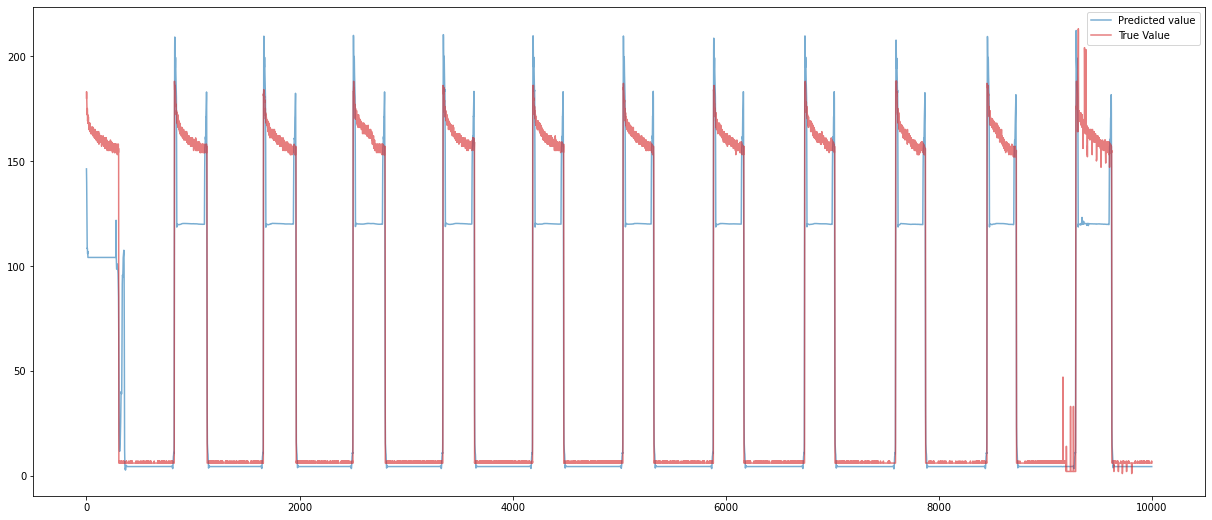

In [ ]:
plt.rcParams["figure.figsize"] = [21,9]
plt.plot((pred.reshape(-1)*MAX_y)[42000:52000], color = 'C0', alpha = 0.6, label = 'Predicted value')
plt.plot((y_test_seg*MAX_y)[42000:52000], color = 'C3', alpha = 0.6, label = 'True Value')
plt.legend()

# plt.savefig('.\\New folder\\CONV1D.png')

## LSTM

In [ ]:
# MIght take 6 min to run

model_CONV1D = load_model("/content/drive/My Drive/EEE312/Fridge_LSTM_w50_5Epoch.h5")
pred= model_CONV1D.predict(X_test_seg)

mse_loss_norm = mse_loss(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)
mae_loss_norm = mae_loss(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)
print('Mean square error on test set: ', mse_loss_norm)
print('Mean absolute error on the test set: ', mae_loss_norm)

rpaf = recall_precision_accuracy_f1(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y, 50)
rete = relative_error_total_energy(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)
mae = mean_absolute_error(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)

print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(rete))
print("============ Mean absolute error(in Watts): {}".format(mae))

Mean square error on test set:  1316.6769381774632
Mean absolute error on the test set:  13.891150665912155
============ Recall: 0.9990046143235999
============ Precision: 0.9132263096321331
============ Accuracy: 0.9574135628853092
============ F1 Score: 0.9541915527199509
============ Relative error in total energy: 0.09521346556515288
============ Mean absolute error(in Watts): 13.891150665912155


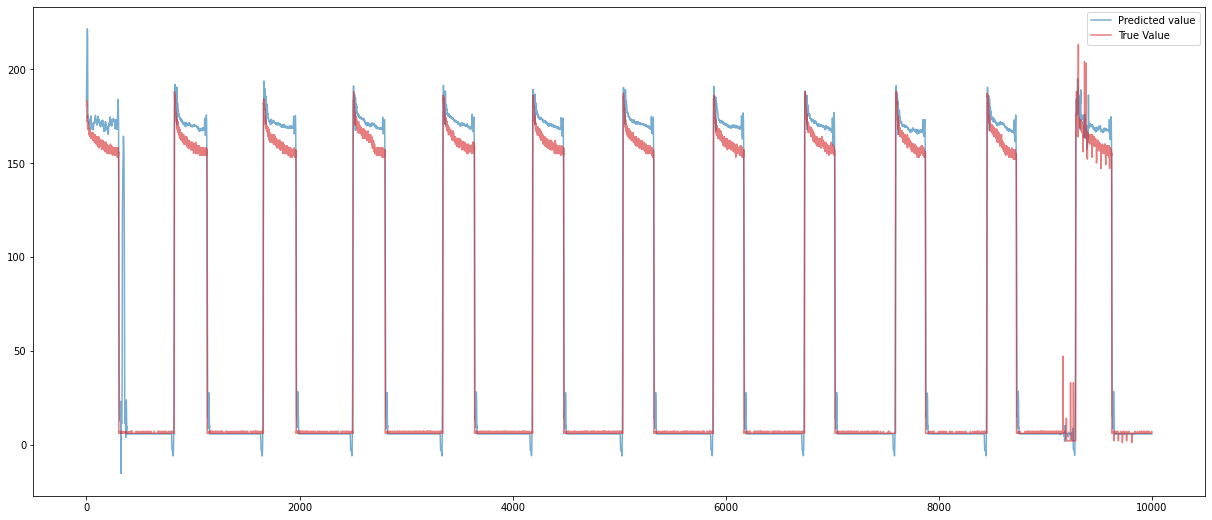

In [ ]:
plt.rcParams["figure.figsize"] = [21,9]
plt.plot((pred.reshape(-1)*MAX_y)[42000:52000], color = 'C0', alpha = 0.6, label = 'Predicted value')
plt.plot((y_test_seg*MAX_y)[42000:52000], color = 'C3', alpha = 0.6, label = 'True Value')
plt.legend()

# plt.savefig('.\\New folder\\CONV1D.png')

In [ ]:
a+b

## GRU

In [ ]:
# MIght take 6 min to run

model_CONV1D = load_model("/content/drive/My Drive/EEE312/Fridge_GRU_w50_5epoch.h5")
pred= model_CONV1D.predict(X_test_seg)

mse_loss_norm = mse_loss(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)
mae_loss_norm = mae_loss(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)
print('Mean square error on test set: ', mse_loss_norm)
print('Mean absolute error on the test set: ', mae_loss_norm)

rpaf = recall_precision_accuracy_f1(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y, 50)
rete = relative_error_total_energy(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)
mae = mean_absolute_error(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)

print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(rete))
print("============ Mean absolute error(in Watts): {}".format(mae))

Mean square error on test set:  2455.880580542376
Mean absolute error on the test set:  27.113234538587733
============ Recall: 0.9956203030238395
============ Precision: 0.8952886945291572
============ Accuracy: 0.9463557992493473
============ F1 Score: 0.942792701811082
============ Relative error in total energy: 0.07813238831188676
============ Mean absolute error(in Watts): 27.113234538587733


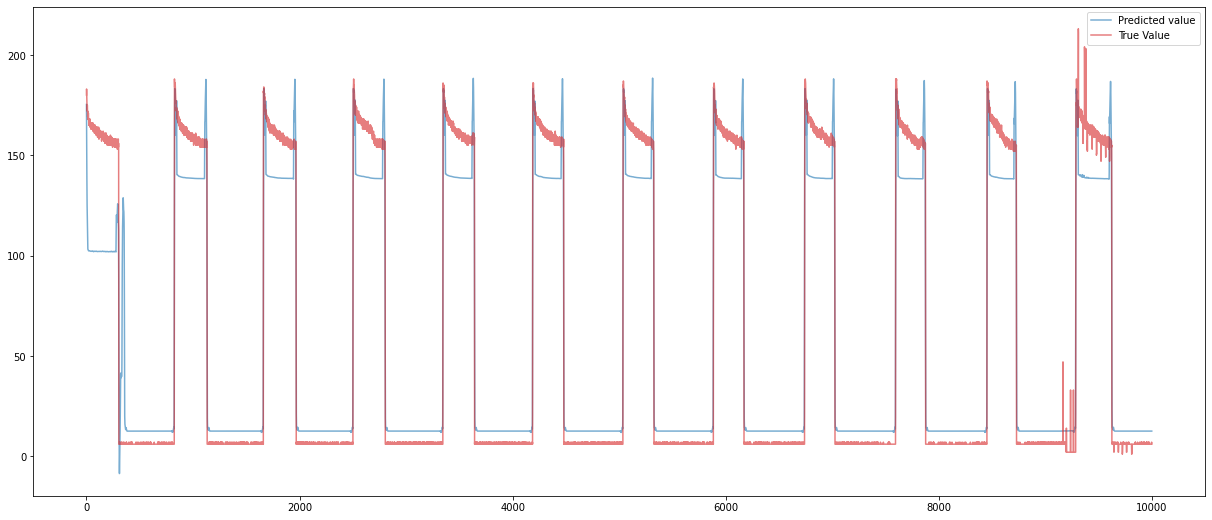

In [ ]:
plt.rcParams["figure.figsize"] = [21,9]
plt.plot((pred.reshape(-1)*MAX_y)[42000:52000], color = 'C0', alpha = 0.6, label = 'Predicted value')
plt.plot((y_test_seg*MAX_y)[42000:52000], color = 'C3', alpha = 0.6, label = 'True Value')
plt.legend()

# plt.savefig('.\\New folder\\CONV1D.png')

## DAE

In [ ]:
model_DAE = load_model("/content/drive/MyDrive/EEE312/Fridge_DAE_w50_5Epoch.h5")

pred_DAE= model_DAE.predict(X_auto_test)

mse_loss_norm = mse_loss(pred_DAE.reshape(-1)*MAX_y, y_auto_test.reshape(-1)*MAX_y)
mae_loss_norm = mae_loss(pred_DAE.reshape(-1)*MAX_y, y_auto_test.reshape(-1)*MAX_y)
print('Mean square error on test set: ', mse_loss_norm)
print('Mean absolute error on the test set: ', mae_loss_norm)

rpaf = recall_precision_accuracy_f1(pred_DAE.reshape(-1)*MAX_y, y_auto_test.reshape(-1)*MAX_y, 10)
rete = relative_error_total_energy(pred_DAE.reshape(-1)*MAX_y, y_auto_test.reshape(-1)*MAX_y)
mae = mean_absolute_error(pred_DAE.reshape(-1)*MAX_y, y_auto_test.reshape(-1)*MAX_y)

print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))


print("============ Relative error in total energy: {}".format(rete))
print("============ Mean absolute error(in Watts): {}".format(mae))

Mean square error on test set:  2830.153466492678
Mean absolute error on the test set:  30.981661290321124
============ Recall: 0.9929437473565487
============ Precision: 0.8216802389341298
============ Accuracy: 0.9003472222222222
============ F1 Score: 0.8992301013763693
============ Relative error in total energy: 0.24430485080830933
============ Mean absolute error(in Watts): 30.981661290321124


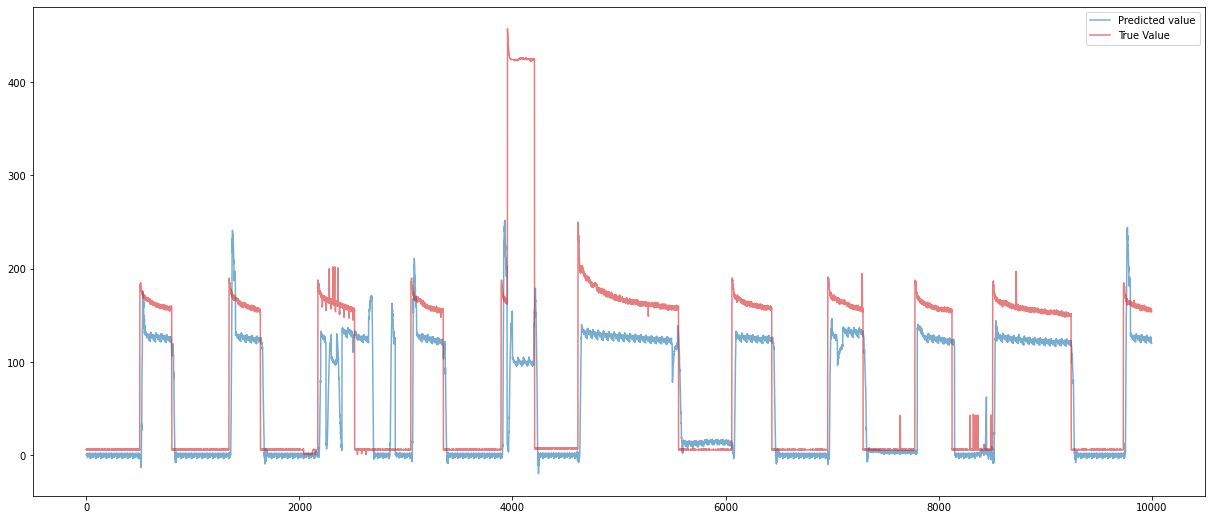

In [ ]:
plt.rcParams["figure.figsize"] = [21,9]
plt.plot((pred_DAE.reshape(-1)*MAX_y)[26000:36000], color = 'C0', alpha = 0.6, label = 'Predicted value')
plt.plot((y_test_seg*MAX_y)[26000:36000], color = 'C3', alpha = 0.6, label = 'True Value')
plt.legend()

# plt.savefig('.\\New folder\\CONV1D.png')

# Light

## Prep

In [ ]:
X1 = df[1]['mains_1'].values.astype(np.float32)
y1 = df[1]['lighting_9'].values.astype(np.float32)
X2 = df[2]['mains_2'].values.astype(np.float32)
y2 = df[2]['lighting_4'].values.astype(np.float32)
X3 = df[3]['mains_2'].values.astype(np.float32)
y3 = df[3]['lighting_11'].values.astype(np.float32)
X4 = df[4]['mains_1'].values.astype(np.float32)
y4 = df[4]['lighting_13'].values.astype(np.float32)
X5 = df[5]['mains_1'].values.astype(np.float32)
y5 = df[5]['lighting_23'].values.astype(np.float32)

Text(0.5, 1.0, 'Aggregated and Refrigerator Power')

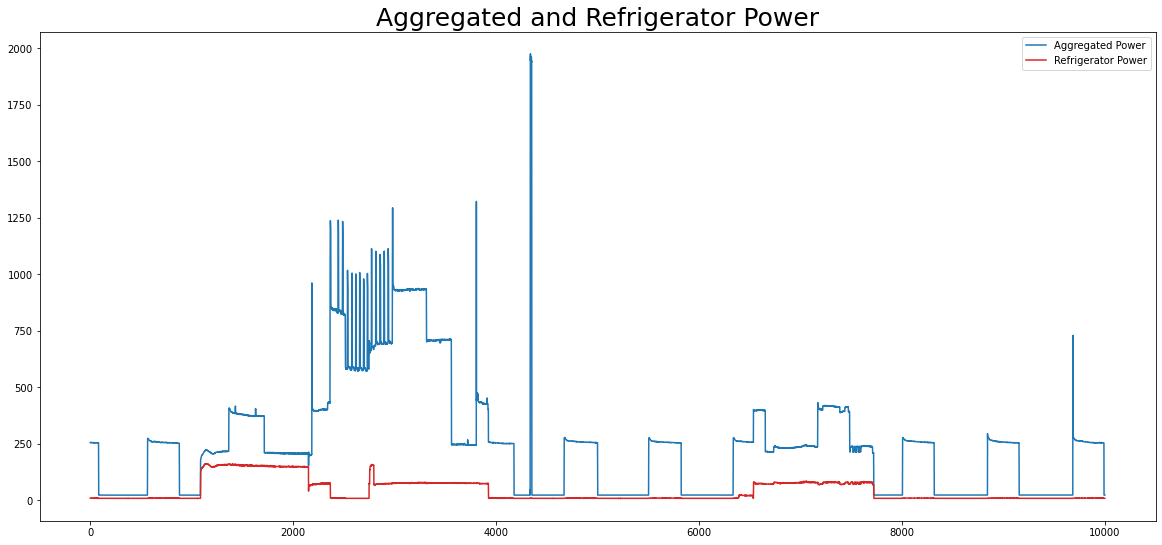

In [ ]:
plt.rcParams["figure.figsize"] = [20,9]
plt.plot((X2)[16000:26000], color = 'C0', label = 'Aggregated Power')
plt.plot((y2)[16000:26000], color = 'C3', label = 'Refrigerator Power')
plt.legend()
plt.title('Aggregated and Refrigerator Power',fontsize=25)

In [ ]:
def remove_abnormal_points(y,left_threshold=200,right_threshold=80):
    y_ = []
    for i,value in enumerate(y):
      
        if i == 0 or i==len(y)-1:
            y_.append(y[i])
        else:
            if y[i]-y[i-1]>left_threshold and y[i]-y[i+1]>right_threshold:
#                        print('index:',i)
                y_.append(y[i+1]+1)
            else:
                y_.append(y[i])
    return np.array(y_)

def get_differential_sequence(X):      
    X_d = []
    pre_item = 0
    for item in X:
        X_d.append(item-pre_item)
        pre_item = item
    X_d = np.array(X_d) # shape = (samples,)
    return X_d

def get_odd_data(X_o, y_o, MAX_X, MAX_y):
    #X_o,y_o = get_house_raw_data(house, self.appliance) 
            
    X_o = remove_abnormal_points(X_o)  
    X_o = X_o/MAX_X # (samples,1)
    #X_d = get_differential_sequence(X_o)  # (samples,)
    #X_dd = get_differential_sequence(X_d) # (samples,)
            
    y_o = remove_abnormal_points(y_o) 
    y_o = y_o/MAX_y # (samples,1)
    #y_d = get_differential_sequence(y_o)  # (samples,)
            
    X = np.expand_dims(X_o,1)  # (samples,3)
    y = np.expand_dims(y_o,1)       # (samples,3)
            
    return X,y 

def shift_segment(X,y,seg_length,stride,print_info=True):
    '''
    X is X_o-X_d-X_dd  shape = (samples,3)
    y is y_o-y_d       shape = (samples,2)
    '''
    X_o_seg = []
    #X_d_seg = []
    #X_dd_seg = []
    y_o_seg = []
    #y_d_seg = []
      
    for i in range(len(X)-seg_length+1):
        if i%stride==0:
            assert len(X[i:i+seg_length]) == seg_length
            X_o_seg.append(  X[i:i+seg_length].reshape(-1) ) 
            #X_d_seg.append(  X[i:i+seg_length,1] )
            #X_dd_seg.append( X[i:i+seg_length,2] )

            y_o_seg.append(  y[i+seg_length//2-1,0] )
            #y_d_seg.append(  y[i+seg_length//2-1,1] )
    if print_info==True:           
        print(' '*7,'sequence length = {}'.format(len(X)))
        print(' '*7,'windows length = {}'.format(seg_length))
        print(' '*7,'stride = {}'.format(stride))
        print(' '*7,'segments =',len(y_o_seg))
    # (segments,seg_length)
    return np.array(X_o_seg), np.array(y_o_seg)#,np.array(X_d_seg), np.array(X_dd_seg)], [np.array(y_o_seg)],np.array(y_d_seg)]


In [ ]:
print('-------- Load Training Data ---------')
first = True
MAX_X = 2000
MAX_y = 200
windows_length = 50
stride = 1

for X,y in [(X1, y1),(X2, y2),(X3, y3),(X4, y4)]:
    
    X_i,y_i = get_odd_data(X, y, MAX_X, MAX_y)
    X_seg_i,y_seg_i = shift_segment(X_i,y_i,windows_length,stride)
    
    print(X_seg_i.shape, y_seg_i.shape)
    
    if first == True:

        X_train = X_i # shape=(samples,3)
        y_train = y_i # shape=(samples,2)
        

        # shape=(samples,seg_length)
        X_o_train_seg = X_seg_i
        y_o_train_seg = y_seg_i

        first = False
    else:
        # shape=(samples+,3)
        X_train = np.vstack((X_train,X_i))
        y_train = np.vstack((y_train,y_i))

        # shape=(samples+,seg_length)
        X_o_train_seg = np.vstack((X_o_train_seg,X_seg_i))
        y_o_train_seg = np.hstack((y_o_train_seg,y_seg_i))

-------- Load Training Data ---------
        sequence length = 406748
        windows length = 50
        stride = 1
        segments = 406699
(406699, 50) (406699,)
        sequence length = 316840
        windows length = 50
        stride = 1
        segments = 316791
(316791, 50) (316791,)
        sequence length = 376150
        windows length = 50
        stride = 1
        segments = 376101
(376101, 50) (376101,)
        sequence length = 428076
        windows length = 50
        stride = 1
        segments = 428027
(428027, 50) (428027,)


In [ ]:
X_train_seg = X_o_train_seg
y_train_seg = y_o_train_seg

In [ ]:
print('-------- Load Testing Data ---------')
X_i,y_i = get_odd_data(X5, y5, MAX_X, MAX_y)
X_seg_i,y_seg_i = shift_segment(X_i,y_i,windows_length,stride)
X_test = X_i   # shape=(samples,3)
y_test = y_i   # shape=(samples,2)
X_test_seg = X_seg_i 
y_test_seg = y_seg_i

-------- Load Testing Data ---------
        sequence length = 77451
        windows length = 50
        stride = 1
        segments = 77402


In [ ]:
print('\nX_train.shape = {}'.format(X_train.shape))
print('y_train.shape = {}'.format(y_train.shape))

print('X_o_train_seg.shape = {}'.format(X_train_seg.shape))
print('y_o_train_seg.shape = {}'.format(y_train_seg.shape))

print('\nX_test.shape = {}'.format(X_test.shape))
print('y_test.shape = {}'.format(y_test.shape))

print('X_o_test_seg.shape = {}'.format(X_test_seg.shape))
print('y_o_test_seg.shape = {}'.format(y_test_seg.shape))


X_train.shape = (1527814, 1)
y_train.shape = (1527814, 1)
X_o_train_seg.shape = (1527618, 50)
y_o_train_seg.shape = (1527618,)

X_test.shape = (77451, 1)
y_test.shape = (77451, 1)
X_o_test_seg.shape = (77402, 50)
y_o_test_seg.shape = (77402,)


In [ ]:
X_train_seg = np.expand_dims(X_train_seg,axis=2) 
X_test_seg = np.expand_dims(X_test_seg,axis=2) 

print('X_o_train_seg.shape = {}'.format(X_train_seg.shape))
print('y_o_train_seg.shape = {}'.format(y_train_seg.shape))

print('X_o_test_seg.shape = {}'.format(X_test_seg.shape))
print('y_o_test_seg.shape = {}'.format(y_test_seg.shape))

X_o_train_seg.shape = (1527618, 50, 1)
y_o_train_seg.shape = (1527618,)
X_o_test_seg.shape = (77402, 50, 1)
y_o_test_seg.shape = (77402,)


In [ ]:
def truncate(X_train1, y_train1, window_size):
    size = X_train1.shape[0]
    index = 1
    while (size-index)%(window_size*2) != 0:
        size -= index
        #print(size)
    return X_train1[:size-1,:], y_train1[:size-1,:]
    
X_train_tru, y_train_tru = truncate(X_train, y_train, windows_length)
X_test_tru, y_test_tru = truncate(X_test, y_test, windows_length)
print(X_train_tru.shape, y_train_tru.shape, X_test_tru.shape, y_test_tru.shape)

X_auto_train = np.reshape(X_train_tru, (int(len(X_train_tru) / windows_length), windows_length, 1))
y_auto_train = np.reshape(y_train_tru, (int(len(y_train_tru) / windows_length), windows_length, 1))
X_auto_test = np.reshape(X_test_tru, (int(len(X_test_tru) / windows_length), windows_length, 1))
y_auto_test = np.reshape(y_test_tru, (int(len( y_test_tru) / windows_length), windows_length, 1))

print(X_auto_train.shape, y_auto_train.shape, X_auto_test.shape, y_auto_test.shape)

(1527800, 1) (1527800, 1) (77400, 1) (77400, 1)
(30556, 50, 1) (30556, 50, 1) (1548, 50, 1) (1548, 50, 1)


## Sequence to point

In [ ]:
model_CONV1D = load_model("/content/drive/MyDrive/EEE312/Light_S2P_w50_5Epoch.h5")
pred= model_CONV1D.predict(X_train_seg)

mse_loss_norm = mse_loss(pred.reshape(-1)*MAX_y, y_train_seg*MAX_y)
mae_loss_norm = mae_loss(pred.reshape(-1)*MAX_y, y_train_seg*MAX_y)
print('Mean square error on test set: ', mse_loss_norm)
print('Mean absolute error on the test set: ', mae_loss_norm)

rpaf = recall_precision_accuracy_f1(pred.reshape(-1)*MAX_y, y_train_seg*MAX_y, 10)
rete = relative_error_total_energy(pred.reshape(-1)*MAX_y, y_train_seg*MAX_y)
mae = mean_absolute_error(pred.reshape(-1)*MAX_y, y_train_seg*MAX_y)

print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(rete))
print("============ Mean absolute error(in Watts): {}".format(mae))

Mean square error on test set:  1872.0561745448802
Mean absolute error on the test set:  27.88164553473781
============ Recall: 1.0
============ Precision: 0.5474850387989667
============ Accuracy: 0.5474850387989667
============ F1 Score: 0.7075803966723717
============ Relative error in total energy: 0.012277775916839567
============ Mean absolute error(in Watts): 27.88164553473781


Text(0, 0.5, 'Generated Power(kW)')

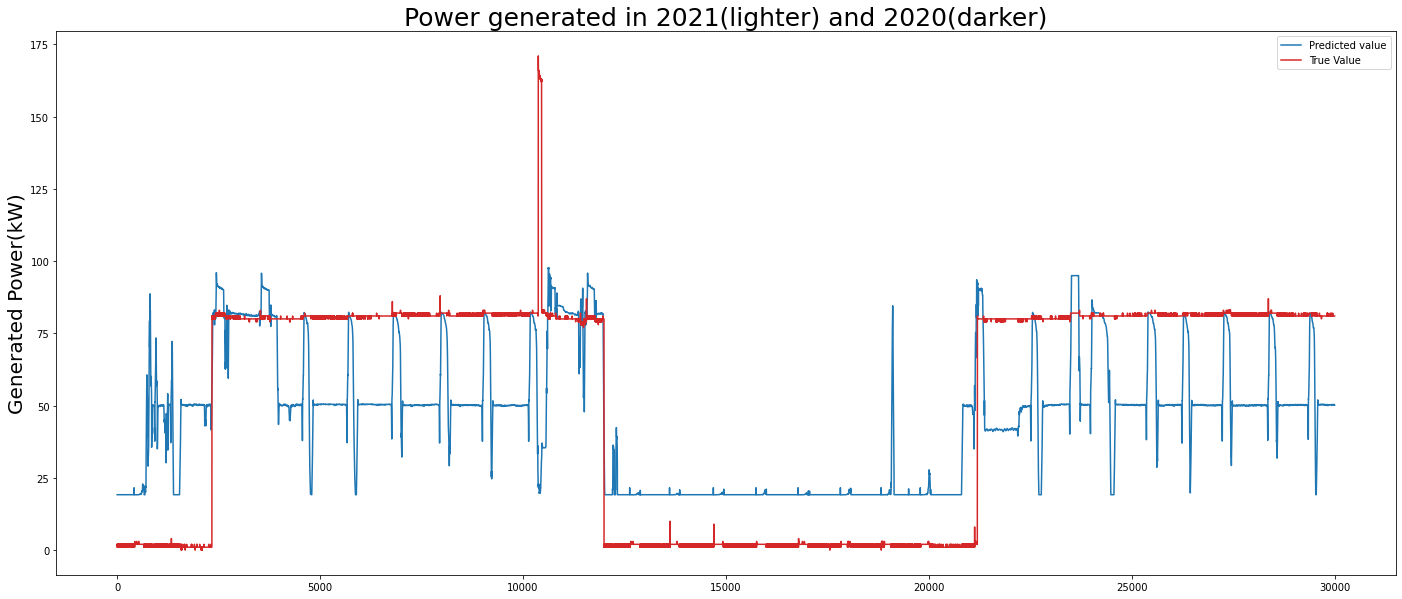

In [ ]:
plt.rcParams["figure.figsize"] = [24,10]
plt.plot((pred.reshape(-1)*MAX_y)[50000:80000], color = 'C0',label = 'Predicted value')
plt.plot((y_train_seg*MAX_y)[50000:80000], color = 'C3', label = 'True Value')
plt.legend()
plt.title('Power generated in 2021(lighter) and 2020(darker)',fontsize=25)
plt.ylabel('Generated Power(kW)', fontsize=20)
# plt.savefig('.\\New folder\\lCONV.png')

## GRU

In [ ]:
model_CONV1D = load_model("/content/drive/MyDrive/EEE312/Light_GRU_w50_5Epoch.h5")
pred= model_CONV1D.predict(X_train_seg)

mse_loss_norm = mse_loss(pred.reshape(-1)*MAX_y, y_train_seg*MAX_y)
mae_loss_norm = mae_loss(pred.reshape(-1)*MAX_y, y_train_seg*MAX_y)
print('Mean square error on test set: ', mse_loss_norm)
print('Mean absolute error on the test set: ', mae_loss_norm)

rpaf = recall_precision_accuracy_f1(pred.reshape(-1)*MAX_y, y_train_seg*MAX_y, 10)
rete = relative_error_total_energy(pred.reshape(-1)*MAX_y, y_train_seg*MAX_y)
mae = mean_absolute_error(pred.reshape(-1)*MAX_y, y_train_seg*MAX_y)

print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(rete))
print("============ Mean absolute error(in Watts): {}".format(mae))

Mean square error on test set:  2008.8954917559788
Mean absolute error on the test set:  32.083808981313766
============ Recall: 0.9881281476131946
============ Precision: 0.5779655019036616
============ Accuracy: 0.5984689889749925
============ F1 Score: 0.7293356702603095
============ Relative error in total energy: 0.17626778887482938
============ Mean absolute error(in Watts): 32.083808981313766


Text(0, 0.5, 'Generated Power(kW)')

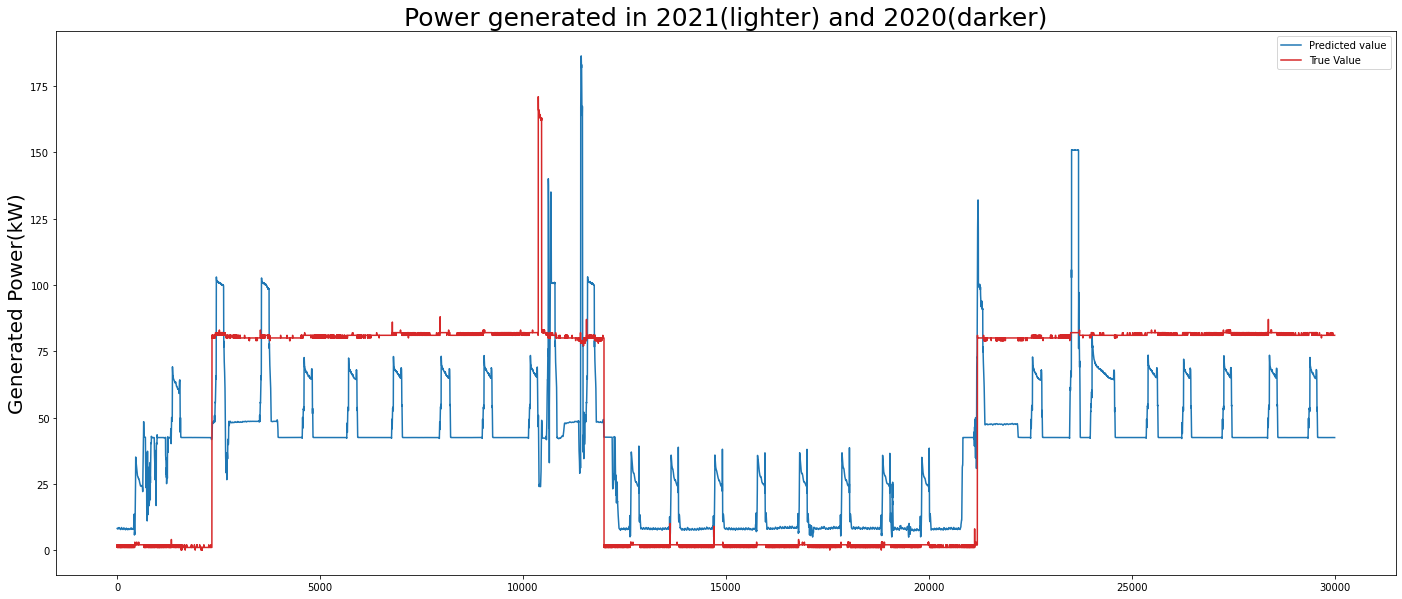

In [ ]:
plt.rcParams["figure.figsize"] = [24,10]
plt.plot((pred.reshape(-1)*MAX_y)[50000:80000], color = 'C0',label = 'Predicted value')
plt.plot((y_train_seg*MAX_y)[50000:80000], color = 'C3', label = 'True Value')
plt.legend()
plt.title('Power generated in 2021(lighter) and 2020(darker)',fontsize=25)
plt.ylabel('Generated Power(kW)', fontsize=20)
# plt.savefig('.\\New folder\\lCONV.png')

In [ ]:
asdfadfsda

## LSTM

In [ ]:
# model_CONV1D = load_model("/content/drive/MyDrive/EEE312/Light_LSTM_w50_5Epoch.h5")
# pred= model_CONV1D.predict(X_train_seg)

# mse_loss_norm = mse_loss(pred.reshape(-1)*MAX_y, y_train_seg*MAX_y)
# mae_loss_norm = mae_loss(pred.reshape(-1)*MAX_y, y_train_seg*MAX_y)
# print('Mean square error on test set: ', mse_loss_norm)
# print('Mean absolute error on the test set: ', mae_loss_norm)

# rpaf = recall_precision_accuracy_f1(pred.reshape(-1)*MAX_y, y_train_seg*MAX_y, 10)
# rete = relative_error_total_energy(pred.reshape(-1)*MAX_y, y_train_seg*MAX_y)
# mae = mean_absolute_error(pred.reshape(-1)*MAX_y, y_train_seg*MAX_y)

# print("============ Recall: {}".format(rpaf[0]))
# print("============ Precision: {}".format(rpaf[1]))
# print("============ Accuracy: {}".format(rpaf[2]))
# print("============ F1 Score: {}".format(rpaf[3]))

# print("============ Relative error in total energy: {}".format(rete))
# print("============ Mean absolute error(in Watts): {}".format(mae))

In [ ]:
plt.rcParams["figure.figsize"] = [24,10]
plt.plot((pred.reshape(-1)*MAX_y)[50000:60000], color = 'C0',label = 'Predicted value')
plt.plot((y_train_seg*MAX_y)[50000:60000], color = 'C3', label = 'True Value')
plt.legend()
plt.title('Power generated in 2021(lighter) and 2020(darker)',fontsize=25)
plt.ylabel('Generated Power(kW)', fontsize=20)
# plt.savefig('.\\New folder\\lCONV.png')

## DAE

In [ ]:
# model_DAE = load_model("/content/drive/MyDrive/EEE312/Light_DAE_w50_5Epoch")

# pred_DAE= new_model1.predict(X_auto_test)

# mse_loss_norm = mse_loss(pred_DAE.reshape(-1)*MAX_y, y_auto_test.reshape(-1)*MAX_y)
# mae_loss_norm = mae_loss(pred_DAE.reshape(-1)*MAX_y, y_auto_test.reshape(-1)*MAX_y)
# print('Mean square error on test set: ', mse_loss_norm)
# print('Mean absolute error on the test set: ', mae_loss_norm)

# rpaf = recall_precision_accuracy_f1(pred_DAE.reshape(-1)*MAX_y, y_auto_test.reshape(-1)*MAX_y, 10)
# rete = relative_error_total_energy(pred_DAE.reshape(-1)*MAX_y, y_auto_test.reshape(-1)*MAX_y)
# mae = mean_absolute_error(pred_DAE.reshape(-1)*MAX_y, y_auto_test.reshape(-1)*MAX_y)

# print("============ Recall: {}".format(rpaf[0]))
# print("============ Precision: {}".format(rpaf[1]))
# print("============ Accuracy: {}".format(rpaf[2]))
# print("============ F1 Score: {}".format(rpaf[3]))


# print("============ Relative error in total energy: {}".format(rete))
# print("============ Mean absolute error(in Watts): {}".format(mae))

In [ ]:
# plt.rcParams["figure.figsize"] = [21,9]
# plt.plot((pred_DAE.reshape(-1)*MAX_y)[15000:36000], color = 'C0', alpha = 0.6, label = 'Predicted value')
# plt.plot((y_test_seg*MAX_y)[15000:36000], color = 'C3', alpha = 0.6, label = 'True Value')
# plt.legend()

# # plt.savefig('.\\New folder\\CONV1D.png')

# Microwave

## Prep

In [ ]:
X1 = df[1]['mains_1'].values.astype(np.float32)
y1 = df[1]['microwave_11'].values.astype(np.float32)
X2 = df[2]['mains_2'].values.astype(np.float32)
y2 = df[2]['microwave_6'].values.astype(np.float32)
X3 = df[3]['mains_1'].values.astype(np.float32)
y3 = df[3]['microwave_16'].values.astype(np.float32)
X5 = df[5]['mains_2'].values.astype(np.float32)
y5 = df[5]['microwave_3'].values.astype(np.float32)

In [ ]:
plt.rcParams["figure.figsize"] = [24,10]
plt.plot((X3)[0000:-1], color = 'red', alpha = 0.6, label = 'Predicted value')
plt.plot((y3)[0000:-1], color = 'blue', alpha = 0.6, label = 'True Value')
plt.legend()

In [ ]:
def remove_abnormal_points(y,left_threshold=200,right_threshold=80):
    y_ = []
    for i,value in enumerate(y):
      
        if i == 0 or i==len(y)-1:
            y_.append(y[i])
        else:
            if y[i]-y[i-1]>left_threshold and y[i]-y[i+1]>right_threshold:
#                        print('index:',i)
                y_.append(y[i+1]+1)
            else:
                y_.append(y[i])
    return np.array(y_)

def get_differential_sequence(X):      
    X_d = []
    pre_item = 0
    for item in X:
        X_d.append(item-pre_item)
        pre_item = item
    X_d = np.array(X_d) # shape = (samples,)
    return X_d

def get_odd_data(X_o, y_o, MAX_X, MAX_y):
    #X_o,y_o = get_house_raw_data(house, self.appliance) 
            
    #X_o = remove_abnormal_points(X_o)  # 去除异常点
    X_o = X_o/MAX_X # (samples,1)
    #X_d = get_differential_sequence(X_o)  # (samples,)
    #X_dd = get_differential_sequence(X_d) # (samples,)
            
    #y_o = remove_abnormal_points(y_o)  # 去除异常点
    y_o = y_o/MAX_y # (samples,1)
    #y_d = get_differential_sequence(y_o)  # (samples,)
            
    X = np.expand_dims(X_o,1)  # (samples,3)
    y = np.expand_dims(y_o,1)       # (samples,3)
            
    return X,y 

def shift_segment(X,y,seg_length,stride,print_info=True):
    '''
    X is X_o-X_d-X_dd  shape = (samples,3)
    y is y_o-y_d       shape = (samples,2)
    '''
    X_o_seg = []
    #X_d_seg = []
    #X_dd_seg = []
    y_o_seg = []
    #y_d_seg = []
      
    for i in range(len(X)-seg_length+1):
        if i%stride==0:
            assert len(X[i:i+seg_length]) == seg_length
            X_o_seg.append(  X[i:i+seg_length].reshape(-1) ) 
            #X_d_seg.append(  X[i:i+seg_length,1] )
            #X_dd_seg.append( X[i:i+seg_length,2] )

            y_o_seg.append(  y[i+seg_length//2-1,0] )
            #y_d_seg.append(  y[i+seg_length//2-1,1] )
    if print_info==True:           
        print(' '*7,'sequence length = {}'.format(len(X)))
        print(' '*7,'windows length = {}'.format(seg_length))
        print(' '*7,'stride = {}'.format(stride))
        print(' '*7,'segments =',len(y_o_seg))
    # (segments,seg_length)
    return np.array(X_o_seg,dtype = np.float32), np.array(y_o_seg,dtype = np.float32)#,np.array(X_d_seg), np.array(X_dd_seg)], [np.array(y_o_seg)],np.array(y_d_seg)]


In [ ]:
print('-------- Load Training Data ---------')
first = True
MAX_X = 2000
MAX_y = 200
windows_length = 100
stride = 1

for X,y in [(X5, y5),(X2, y2),(X3, y3)]:
    
    X_i,y_i = get_odd_data(X, y, MAX_X, MAX_y)
    X_seg_i,y_seg_i = shift_segment(X_i,y_i,windows_length,stride)
    
    print(X_seg_i.shape, y_seg_i.shape)
    
    if first == True:

        X_train = X_i # shape=(samples,3)
        y_train = y_i # shape=(samples,2)
        

        # shape=(samples,seg_length)
        X_o_train_seg = X_seg_i
        y_o_train_seg = y_seg_i

        first = False
    else:
        # shape=(samples+,3)
        X_train = np.vstack((X_train,X_i))
        y_train = np.vstack((y_train,y_i))

        # shape=(samples+,seg_length)
        X_o_train_seg = np.vstack((X_o_train_seg,X_seg_i))
        y_o_train_seg = np.hstack((y_o_train_seg,y_seg_i))

In [ ]:
X_train_seg = X_o_train_seg
y_train_seg = y_o_train_seg

In [ ]:
print('-------- Load Testing Data ---------')
X_i,y_i = get_odd_data(X1, y1, MAX_X, MAX_y)
X_seg_i,y_seg_i = shift_segment(X_i,y_i,windows_length,stride)
X_test = X_i   # shape=(samples,3)
y_test = y_i   # shape=(samples,2)
X_test_seg = X_seg_i 
y_test_seg = y_seg_i

In [ ]:
print('\nX_train.shape = {}'.format(X_train.shape))
print('y_train.shape = {}'.format(y_train.shape))

print('X_o_train_seg.shape = {}'.format(X_train_seg.shape))
print('y_o_train_seg.shape = {}'.format(y_train_seg.shape))

print('\nX_test.shape = {}'.format(X_test.shape))
print('y_test.shape = {}'.format(y_test.shape))

print('X_o_test_seg.shape = {}'.format(X_test_seg.shape))
print('y_o_test_seg.shape = {}'.format(y_test_seg.shape))

In [ ]:
X_train_seg = np.expand_dims(X_train_seg,axis=2) 
X_test_seg = np.expand_dims(X_test_seg,axis=2) 

print('X_o_train_seg.shape = {}'.format(X_train_seg.shape))
print('y_o_train_seg.shape = {}'.format(y_train_seg.shape))

print('X_o_test_seg.shape = {}'.format(X_test_seg.shape))
print('y_o_test_seg.shape = {}'.format(y_test_seg.shape))

In [ ]:
def truncate(X_train1, y_train1, window_size):
    size = X_train1.shape[0]
    index = 1
    while (size-index)%(window_size*2) != 0:
        size -= index
        #print(size)
    return X_train1[:size-1,:], y_train1[:size-1,:]
    
X_train_tru, y_train_tru = truncate(X_train, y_train, windows_length)
X_test_tru, y_test_tru = truncate(X_test, y_test, windows_length)
print(X_train_tru.shape, y_train_tru.shape, X_test_tru.shape, y_test_tru.shape)

X_auto_train = np.reshape(X_train_tru, (int(len(X_train_tru) / windows_length), windows_length, 1))
y_auto_train = np.reshape(y_train_tru, (int(len(y_train_tru) / windows_length), windows_length, 1))
X_auto_test = np.reshape(X_test_tru, (int(len(X_test_tru) / windows_length), windows_length, 1))
y_auto_test = np.reshape(y_test_tru, (int(len( y_test_tru) / windows_length), windows_length, 1))

print(X_auto_train.shape, y_auto_train.shape, X_auto_test.shape, y_auto_test.shape)

## Sequence to Point

In [ ]:
# MIght take 6 min to run

model_CONV1D = load_model("/content/drive/My Drive/EEE312/Microwave_S2P_w50_5Epoch.h5")
pred= model_CONV1D.predict(X_test_seg)

mse_loss_norm = mse_loss(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)
mae_loss_norm = mae_loss(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)
print('Mean square error on test set: ', mse_loss_norm)
print('Mean absolute error on the test set: ', mae_loss_norm)

rpaf = recall_precision_accuracy_f1(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y, 50)
rete = relative_error_total_energy(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)
mae = mean_absolute_error(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)

print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(rete))
print("============ Mean absolute error(in Watts): {}".format(mae))

In [ ]:
plt.rcParams["figure.figsize"] = [24,10]
plt.plot((pred.reshape(-1)*MAX_y)[30000:40000], color = 'C0', label = 'Predicted value')
plt.plot((y_test_seg*MAX_y)[30000:40000], color = 'C3', alpha = 0.6, label = 'True Value')
plt.legend()
plt.savefig('.\\New folder\\MicrowaveConv1D.png')

## GRU

In [ ]:
# # MIght take 6 min to run

# # model_CONV1D = load_model("/content/drive/My Drive/EEE312/Microwave_S2P_w50_5Epoch.h5")
# pred= new_model1.predict(X_test_seg)

# mse_loss_norm = mse_loss(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)
# mae_loss_norm = mae_loss(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)
# print('Mean square error on test set: ', mse_loss_norm)
# print('Mean absolute error on the test set: ', mae_loss_norm)

# rpaf = recall_precision_accuracy_f1(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y, 50)
# rete = relative_error_total_energy(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)
# mae = mean_absolute_error(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)

# print("============ Recall: {}".format(rpaf[0]))
# print("============ Precision: {}".format(rpaf[1]))
# print("============ Accuracy: {}".format(rpaf[2]))
# print("============ F1 Score: {}".format(rpaf[3]))

# print("============ Relative error in total energy: {}".format(rete))
# print("============ Mean absolute error(in Watts): {}".format(mae))

In [ ]:
plt.rcParams["figure.figsize"] = [21,9]
plt.plot((pred.reshape(-1)*MAX_y)[15000:36000], color = 'C0', alpha = 0.6, label = 'Predicted value')
plt.plot((y_test_seg*MAX_y)[15000:36000], color = 'C3', alpha = 0.6, label = 'True Value')
plt.legend()

# plt.savefig('.\\New folder\\CONV1D.png')

## LSTM

In [ ]:
# # MIght take 6 min to run

# # model_CONV1D = load_model("/content/drive/My Drive/EEE312/Microwave_S2P_w50_5Epoch.h5")
# pred= new_model1.predict(X_test_seg)

# mse_loss_norm = mse_loss(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)
# mae_loss_norm = mae_loss(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)
# print('Mean square error on test set: ', mse_loss_norm)
# print('Mean absolute error on the test set: ', mae_loss_norm)

# rpaf = recall_precision_accuracy_f1(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y, 50)
# rete = relative_error_total_energy(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)
# mae = mean_absolute_error(pred.reshape(-1)*MAX_y, y_test_seg*MAX_y)

# print("============ Recall: {}".format(rpaf[0]))
# print("============ Precision: {}".format(rpaf[1]))
# print("============ Accuracy: {}".format(rpaf[2]))
# print("============ F1 Score: {}".format(rpaf[3]))

# print("============ Relative error in total energy: {}".format(rete))
# print("============ Mean absolute error(in Watts): {}".format(mae))

In [ ]:
plt.rcParams["figure.figsize"] = [21,9]
plt.plot((pred.reshape(-1)*MAX_y)[15000:36000], color = 'C0', alpha = 0.6, label = 'Predicted value')
plt.plot((y_test_seg*MAX_y)[15000:36000], color = 'C3', alpha = 0.6, label = 'True Value')
plt.legend()

# plt.savefig('.\\New folder\\CONV1D.png')

## DAE

In [ ]:
# model_DAE = load_model("/content/drive/MyDrive/EEE312/Microwave_DAE_w50_5Epoch.h5")

pred_DAE= new_model1.predict(X_auto_test)

mse_loss_norm = mse_loss(pred_DAE.reshape(-1)*MAX_y, y_auto_test.reshape(-1)*MAX_y)
mae_loss_norm = mae_loss(pred_DAE.reshape(-1)*MAX_y, y_auto_test.reshape(-1)*MAX_y)
print('Mean square error on test set: ', mse_loss_norm)
print('Mean absolute error on the test set: ', mae_loss_norm)

rpaf = recall_precision_accuracy_f1(pred_DAE.reshape(-1)*MAX_y, y_auto_test.reshape(-1)*MAX_y, 10)
rete = relative_error_total_energy(pred_DAE.reshape(-1)*MAX_y, y_auto_test.reshape(-1)*MAX_y)
mae = mean_absolute_error(pred_DAE.reshape(-1)*MAX_y, y_auto_test.reshape(-1)*MAX_y)

print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))


print("============ Relative error in total energy: {}".format(rete))
print("============ Mean absolute error(in Watts): {}".format(mae))

In [ ]:
plt.rcParams["figure.figsize"] = [21,9]
plt.plot((pred.reshape(-1)*MAX_y)[15000:36000], color = 'C0', alpha = 0.6, label = 'Predicted value')
plt.plot((y_test_seg*MAX_y)[15000:36000], color = 'C3', alpha = 0.6, label = 'True Value')
plt.legend()

# plt.savefig('.\\New folder\\CONV1D.png')